# DSCI HW 1

> By Tianzuo Zhang
> 
> USC ID: 8849-5991-30
> 
> My contact info: [Twitter](https://twitter.com/dvzhangtz) [Linkedin](https://www.linkedin.com/in/tianzuo-zhang/) Wechat: dvzhangtz

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from multiprocess.pool import Pool

# TODO: I use multiprocess, please define the num of your processor this line
processor = 10

#### (a) Download
Download the Vertebral Column Data Set from: [link](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column).

In [139]:
dataPath = r"../Homework 1 Data/vertebral_column_data/column_2C.dat"
colomnName = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", 
         "sacral_slope", "pelvic_radius", "grade_of_spondylolisthesis", "label"]

data = pd.read_csv(dataPath, header = None, sep = "\s+", names = colomnName)
print(data.head())
print("*"*30)
print(data.isnull().sum())
print("*"*30)
print(data.groupby(['label'])['label'].count())


   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0             63.03        22.55                  39.61         40.48   
1             39.06        10.06                  25.02         29.00   
2             68.83        22.22                  50.09         46.61   
3             69.30        24.65                  44.31         44.64   
4             49.71         9.65                  28.32         40.06   

   pelvic_radius  grade_of_spondylolisthesis label  
0          98.67                       -0.25    AB  
1         114.41                        4.56    AB  
2         105.99                       -3.53    AB  
3         101.87                       11.21    AB  
4         108.17                        7.92    AB  
******************************
pelvic_incidence              0
pelvic_tilt                   0
lumbar_lordosis_angle         0
sacral_slope                  0
pelvic_radius                 0
grade_of_spondylolisthesis    0
label               

#### (b) EDA
Pre-Processing and Exploratory data analysis:

i. Make scatterplots of the independent variables in the dataset. Use color to show Classes 0 and 1.

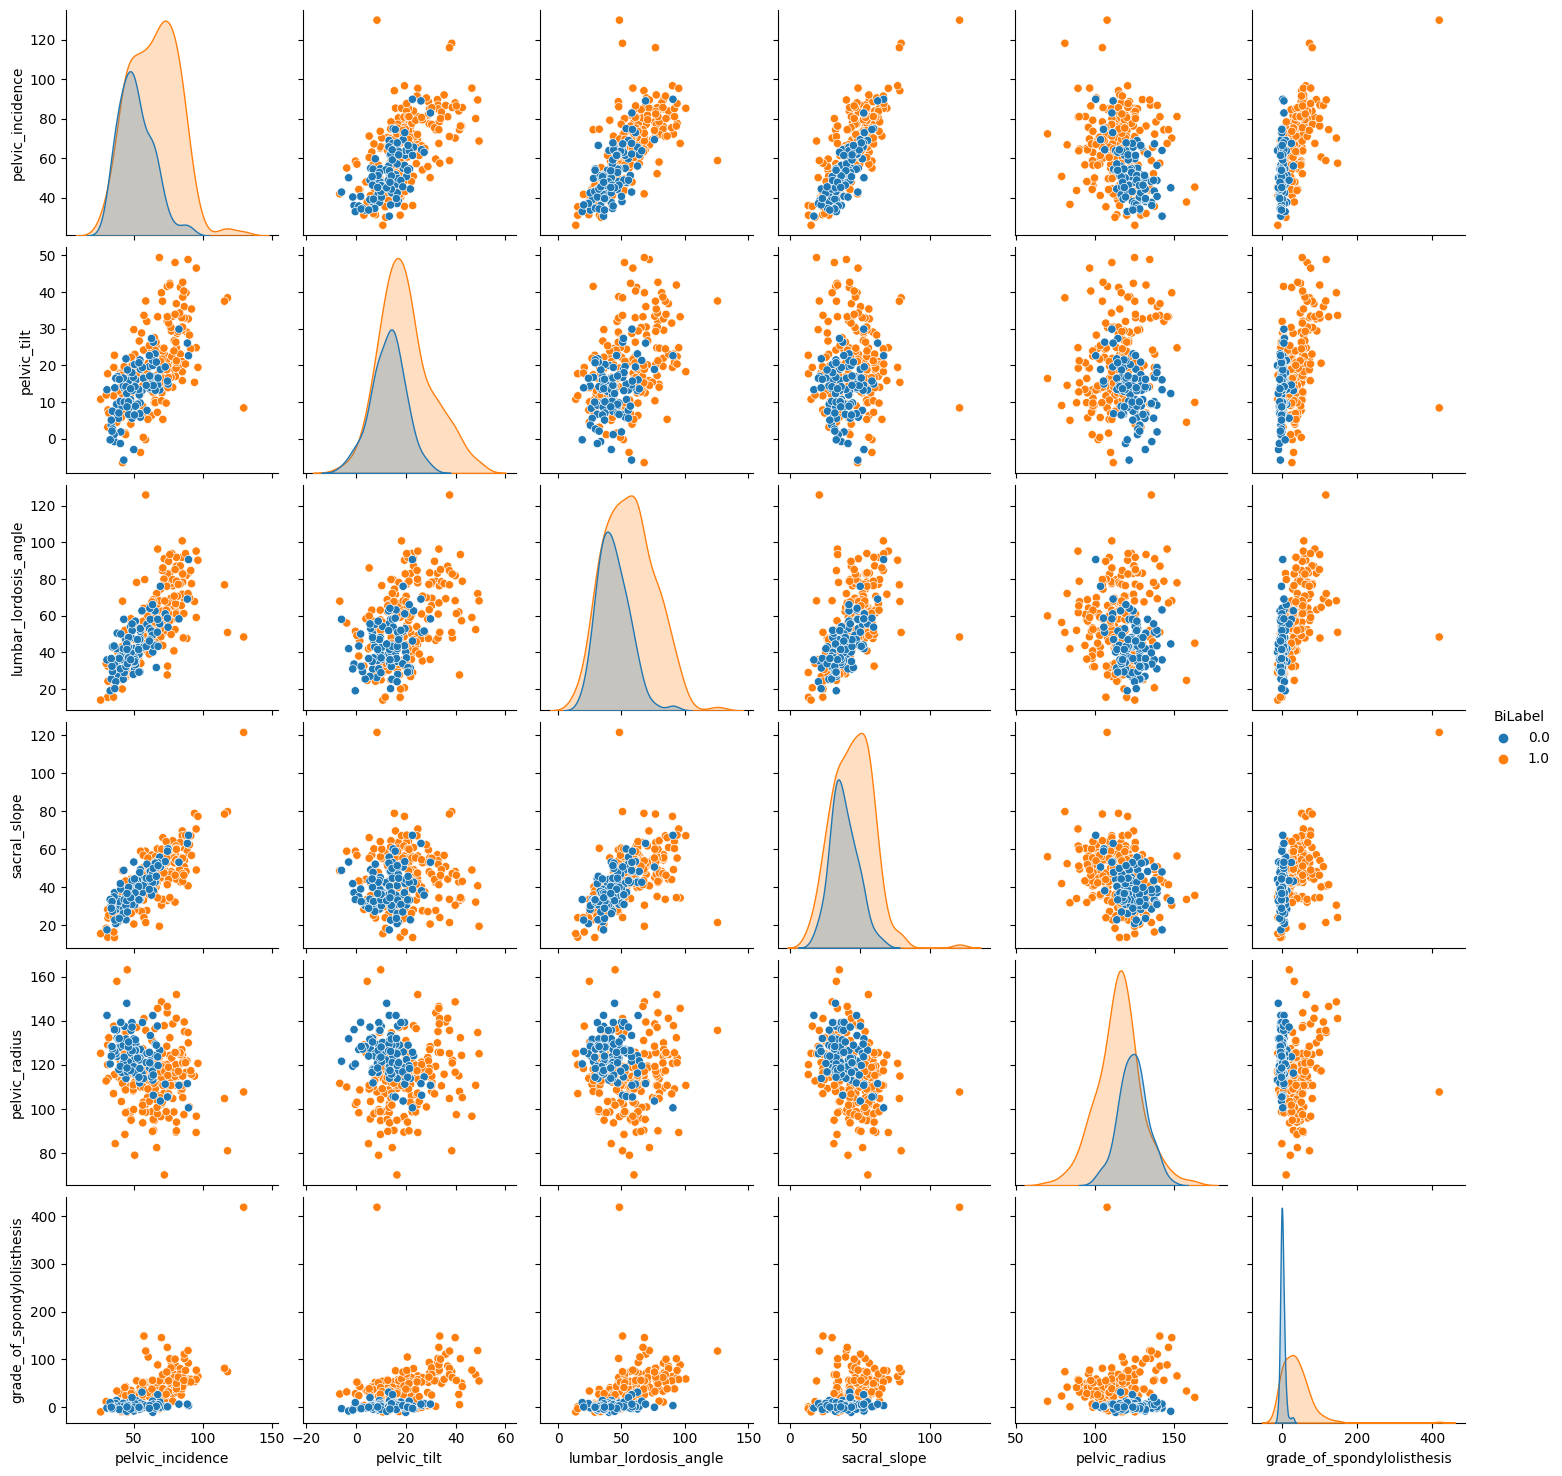

In [140]:
data.loc[data["label"] == "NO", "BiLabel"] = int(0)
data.loc[data["label"] == "AB", "BiLabel"] = int(1)

scatterPlot = sns.pairplot(data, hue="BiLabel")
plt.show()

ii. Make boxplots for each of the independent variables. Use color to show Classes 0 and 1 (see ISLR p. 129).

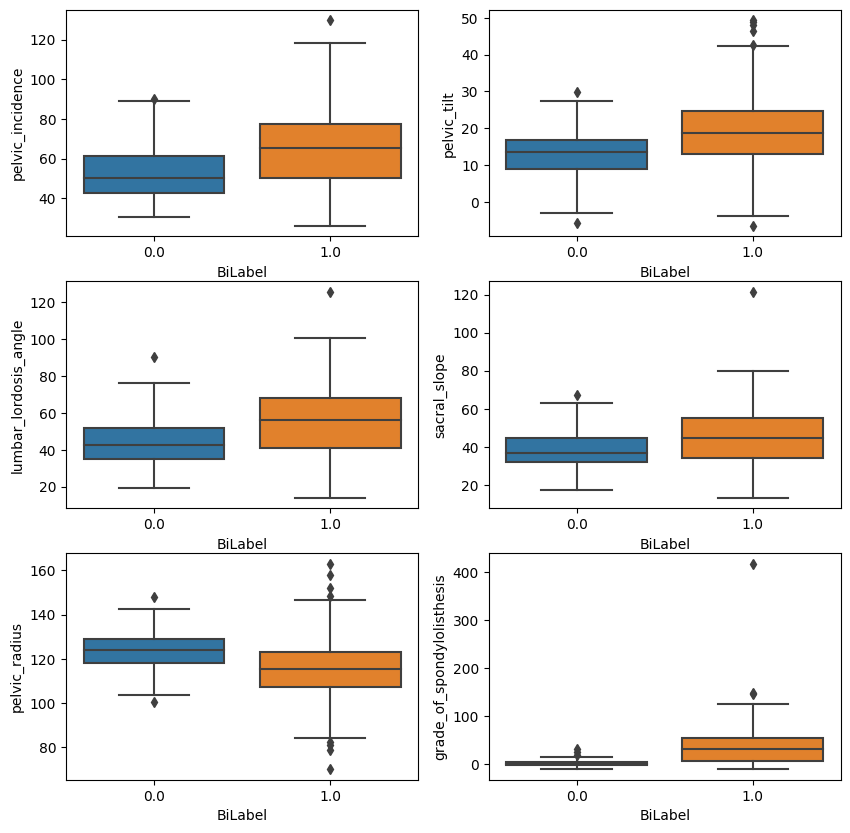

In [141]:
fig, axes = plt.subplots(3, 2, figsize = (10, 10))
for i in range(6):
    sns.boxplot(data = data, x="BiLabel", y=colomnName[i], ax = axes[i//2, i%2])
plt.show()

iii. Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the training set and the rest of the data as the test set.

In [142]:
train_NO, test_NO = data[data["BiLabel"] == 0].iloc[:70], data[data["BiLabel"] == 0].iloc[70:]
train_AB, test_AB = data[data["BiLabel"] == 1].iloc[:140], data[data["BiLabel"] == 1].iloc[140:]

train_set = pd.concat([train_NO, train_AB], ignore_index=True)
test_set = pd.concat([test_NO, test_AB], ignore_index=True)

# print(train_set.head())
print(train_set.describe())
print("*"*50)
# print(test_set.head())
print(test_set.describe())

       pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
count        210.000000   210.000000             210.000000    210.000000   
mean          58.242429    17.226429              48.788143     41.016381   
std           16.697671     9.130719              16.895211     13.454336   
min           26.150000    -6.550000              14.000000     13.370000   
25%           44.640000    10.760000              35.925000     31.705000   
50%           55.120000    16.525000              47.000000     39.885000   
75%           70.355000    21.895000              59.202500     49.762500   
max          129.830000    48.070000              93.890000    121.430000   

       pelvic_radius  grade_of_spondylolisthesis     BiLabel  
count     210.000000                  210.000000  210.000000  
mean      120.014810                   22.158905    0.666667  
std        11.445649                   39.749669    0.472531  
min        84.240000                  -11.060000    0.

#### (c) KNN
Classification using KNN on Vertebral Column Data Set

i. Write code for k-nearest neighbors with Euclidean metric (or use a software package).

In [143]:
def takeFirst(elem):
    return elem[0]

class KNN:
    def __init__(self, k, metric, p=1, weighted=False):
        self.k = k
        self.metric = metric
        self.p = p
        self.weighted=weighted
    
    def fit(self, train_input, train_output, test_input, test_output):
        output = []
        if self.metric == 'mahalanobis':
            covI = np.linalg.inv(train_input.cov())
            
        for i in range(test_input.shape[0]):
            dis_results = []
            
            for j in range(train_input.shape[0]):
                if self.metric == "Euclidean" or self.metric == "euclidean":
                    distance = self.Euclidean_metric(test_input.iloc[i], train_input.iloc[j])
                    dis_results.append([distance, j])
                if self.metric == "manhattan":
                    distance = self.Minikowski_metric(test_input.iloc[i], train_input.iloc[j], 1)
                    dis_results.append([distance, j])
                if self.metric == "minkowski":
                    distance = self.Minikowski_metric(test_input.iloc[i], train_input.iloc[j], self.p)
                    dis_results.append([distance, j])
                if self.metric == "chebyshev":
                    distance = self.chebyshev_metric(test_input.iloc[i], train_input.iloc[j])
                    dis_results.append([distance, j])
                if self.metric == 'mahalanobis':
                    distance = self.mahalanobis_metric(test_input.iloc[i], train_input.iloc[j], covI)
                    dis_results.append([distance, j])
                    
            dis_results.sort(key=takeFirst)
            vote = 0
            for voter in dis_results[:min(self.k, len(dis_results))]:
                distance, line = voter[0], voter[1]
                if self.weighted:
                    if distance == 0:
                        distance = 0.000001
                    vote += (1 / -distance) if train_output.iloc[line] == 0 else (1 / distance)
                    continue
                if train_output.iloc[line]:
                    vote += 1
                else:
                    vote -= 1
            output.append(0 if vote<= 0 else 1)
        acc = recall_score(test_output.values.tolist(), output, average='macro')
        error_rate = (test_output.values != output).sum() / len(output)
        
        confusianmMatrix = confusion_matrix(test_output.to_numpy('int64'), np.array(output))
        
        return {
            "results": output,
            "acc": acc,
            "confusion_matrix": confusianmMatrix,
            "error_rate": error_rate
        }
            
                
    def Euclidean_metric(self, vec1, vec2):
        return np.linalg.norm(vec1.to_numpy() - vec2.to_numpy())
    
    def Minikowski_metric(self, vec1, vec2, p):
        return np.linalg.norm(vec1.to_numpy() - vec2.to_numpy(), ord=p)
    
    def chebyshev_metric(self, vec1, vec2):
        return np.max(np.abs(vec1.to_numpy() - vec2.to_numpy()))
    
    def mahalanobis_metric(self, vec1, vec2, covI):
        delta = vec1.to_numpy() - vec2.to_numpy()
        #m = np.dot(np.dot(delta, covI), delta.T)
        m = delta@covI@delta.T
        return np.sqrt(m);

ii. Test all the data in the test database with k nearest neighbors. Take decisions by majority polling. 

In [144]:
step = -3
k_range = range(208, 0, step)
# k_range = range(8, 0, step)

bestK = []
bestError = []

train_input = train_set.iloc[:,:-2]
train_output = train_set.iloc[:,-1]
test_input = test_set.iloc[:,:-2]
test_output = test_set.iloc[:,-1]
    
def signal_for_multiThread_forK(k_range = range(208, 0, step)):
    signals = []
    for k in k_range:
        signals.append([k,train_input,train_output,test_input,test_output])
    return signals

In [145]:
def calculate_KNN_by_one_loop(signal):
    min_error = 1
    k,train_input,train_output,test_input,test_output = signal
    
    knn = KNN(k, "Euclidean")
    results_train = knn.fit(train_input, train_output, train_input, train_output)
    # error_train.append(results_train["error_rate"])
    results_test = knn.fit(train_input, train_output, test_input, test_output)
    # error_test.append(results_test["error_rate"])
    return [k, results_train, results_test]

In [146]:
multi_signals_forK = signal_for_multiThread_forK()
with Pool(processes=processor) as pool:
    results_list = pool.map(calculate_KNN_by_one_loop, multi_signals_forK)
results_list.sort(key = takeFirst)

In [147]:
error_train = [r[1]["error_rate"] for r in results_list]
error_test = [r[2]["error_rate"] for r in results_list]

min_error_test = 1
for i in range(len(error_test)):
    if error_test[i] <= min_error_test:
        best_result = results_list[i][0]
        min_error_test = error_test[i]
        
error_train = error_train[::-1]
error_test = error_test[::-1]

Plot train and test errors in terms of k for k ∈ {208, 205, . . . , 7, 4, 1, } (in reverse order). You are welcome to use smaller increments of k. 

[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.28, 0.27, 0.24, 0.23, 0.2, 0.22, 0.15, 0.2, 0.16, 0.16, 0.14, 0.18, 0.14, 0.16, 0.15, 0.16, 0.17, 0.16, 0.14, 0.13, 0.12, 0.13, 0.12, 0.13, 0.12, 0.12, 0.12, 0.12, 0.11, 0.11, 0.12, 0.12, 0.1, 0.11, 0.11, 0.11, 0.1, 0.11, 0.1, 0.11, 0.09, 0.12, 0.1, 0.12, 0.06, 0.13]


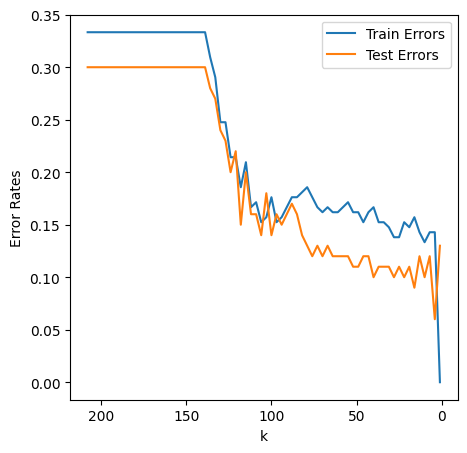

In [148]:
fig, axes = plt.subplots(1, 1, figsize=(5,5))
print(error_test)
# plot error_rate fig
axes.plot(k_range, error_train, label="Train Errors")
axes.plot(k_range, error_test, label="Test Errors")
axes.invert_xaxis()
axes.set_xlabel("k")
axes.set_ylabel("Error Rates")
axes.legend()
plt.show()

Which k∗ is the most suitable k among those values? 

In [149]:
print("Best K is: {}".format(best_result))

Best K is: 4


Calculate the confusion matrix, true positive rate, true negative rate, precision, and F1-score when k = k∗.2

In [150]:
knn = KNN(4, "Euclidean")
best_results = knn.fit(train_input, train_output, test_input, test_output)
confusionMatrix = best_results["confusion_matrix"]

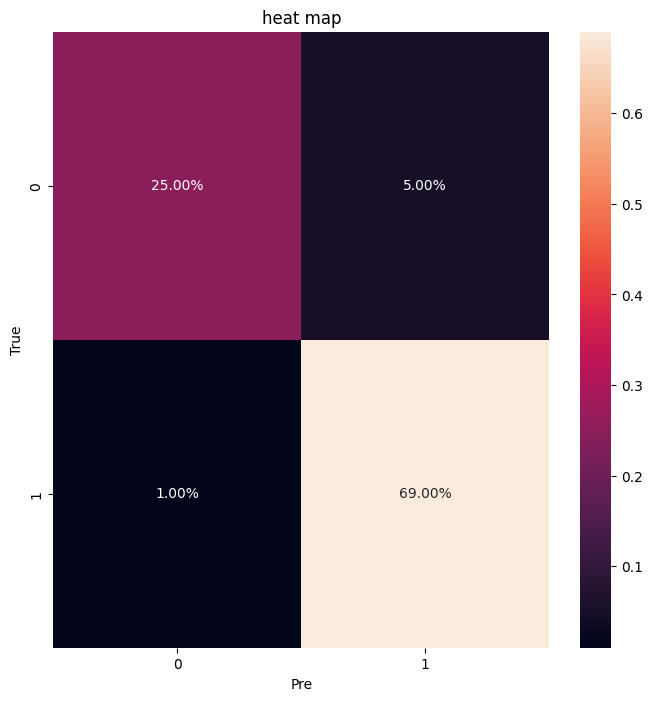

truePosRate: 0.8333333333333334
trueNegRate: 0.9857142857142858
******************************
precision_0: 0.9615384615384616
precision_1: 0.9324324324324325
******************************
recall_0: 0.8333333333333334
recall_1: 0.9857142857142858
******************************
f1_1: 0.9583333333333333
f1_0: 0.8928571428571429
******************************


In [151]:
class evaluator:
    def __init__(self):
        pass
    
    def evaluation(self, confusionMatrix):
        self.printMat(confusionMatrix)
        self.true_positive(confusionMatrix)
        self.true_negative(confusionMatrix)
        self.precisionF1(confusionMatrix)
        
    def printMat(self, confusionMatrix):
        fig, axe = plt.subplots(1, 1, figsize=(8, 8))
        sns.heatmap((confusionMatrix / np.sum(confusionMatrix)), annot=True, fmt='.2%')
        plt.title('heat map')
        plt.xlabel('Pre')
        plt.ylabel('True')
        plt.show()

    def true_positive(self, confusionMatrix):
        truePositive = confusionMatrix[0, 0]
        falsePositive = confusionMatrix[1, 0]
        trueNegative = confusionMatrix[1, 1]
        falseNegative = confusionMatrix[0, 1]
        truePosRate = truePositive / (truePositive + falseNegative)
        print("truePosRate: {}".format(truePosRate))
        return truePosRate
        
    def true_negative(self, confusionMatrix):
        truePositive = confusionMatrix[0, 0]
        falsePositive = confusionMatrix[1, 0]
        trueNegative = confusionMatrix[1, 1]
        falseNegative = confusionMatrix[0, 1]
        trueNegRate = trueNegative / (trueNegative + falsePositive)
        print("trueNegRate: {}".format(trueNegRate))
        return trueNegRate
        
    def precisionF1(self, confusionMatrix):
        truePositive = confusionMatrix[0, 0]
        falsePositive = confusionMatrix[1, 0]
        trueNegative = confusionMatrix[1, 1]
        falseNegative = confusionMatrix[0, 1]
        precision_0 = truePositive / (truePositive + falsePositive)
        precision_1 = trueNegative / (trueNegative + falseNegative)
        recall_0 = truePositive / (truePositive + falseNegative)
        recall_1 = trueNegative / (trueNegative + falsePositive)
        f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
        f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)
        print("*"*30)
        print("precision_0: {}".format(precision_0))
        print("precision_1: {}".format(precision_1))
        print("*"*30)
        print("recall_0: {}".format(recall_0))
        print("recall_1: {}".format(recall_1))
        print("*"*30)
        print("f1_1: {}".format(f1_1))
        print("f1_0: {}".format(f1_0))
        print("*"*30)
        
        return precision_0, precision_1, recall_0, recall_1, f1_1, f1_0

eval = evaluator()
eval.evaluation(confusionMatrix)

iii. Since the computation time depends on the size of the training set, one may only use a subset of the training set. Plot the best test error rate, which is obtained by some value of k, against the size of training set, when the size of training set is N ∈ {10, 20, 30, . . . , 210}.
Note: for each N, select your training set by choosing the first bN/3c rows of Class 0 and the first N − bN/3c rows of Class 1 in the training set you created in 1(b)iii. Also, for
each N, select the optimal k from a set starting from k = 1, increasing by 5. For example, if N = 200, the optimal k is selected from {1, 6, 11, . . . , 196}. This plot is called a Learning Curve.
Let us further explore some variants of KNN.

In [152]:
N_range = range(10, 211, 10)
# N_range = range(10, 21, 10)

bestK = []
bestError = []
    
def signal_for_multiThread(N_range = range(10, 211, 10)):
    signals = []
    for N in N_range:
        N_data = pd.concat([train_set[train_set["BiLabel"] == 0].iloc[0: N//3, :],
                        train_set[train_set["BiLabel"] == 1].iloc[0: N - N//3, :],
                        ], ignore_index=True)
        N_train_input = N_data.iloc[:, :-2]
        N_train_output = N_data.iloc[:, -1]
        signals.append([N, N_train_input, N_train_output, test_input, test_output])
    return signals

In [153]:
def calculate_by_one_loop(signal):
    min_error = 1
    N, N_train_input, N_train_output, test_input, test_output = signal
    for k in range(1, N, 5):
        knn = KNN(k, "Euclidean")
        
        results = knn.fit(N_train_input, N_train_output, test_input, test_output)
        # error_test.append(results["error_rate"])
        if results["error_rate"] <= min_error:
            min_error, best_result = results["error_rate"], k
            
    # rtn = pd.DataFrame()
    # rtn.loc[0, 'N'] = N
    # rtn.loc[0, 'best_result'] = best_result
    # rtn.loc[0, 'min_error'] = min_error
    # return rtn
    return N, best_result, min_error

    

In [154]:
multi_signals = signal_for_multiThread()
with Pool(processes=processor) as pool:
    results_list = pool.map(calculate_by_one_loop, multi_signals)

    # bestK.append(best_result)
    # bestError.append(min_error)
results_list.sort(key = takeFirst)
bestError = [result[2] for result in results_list]


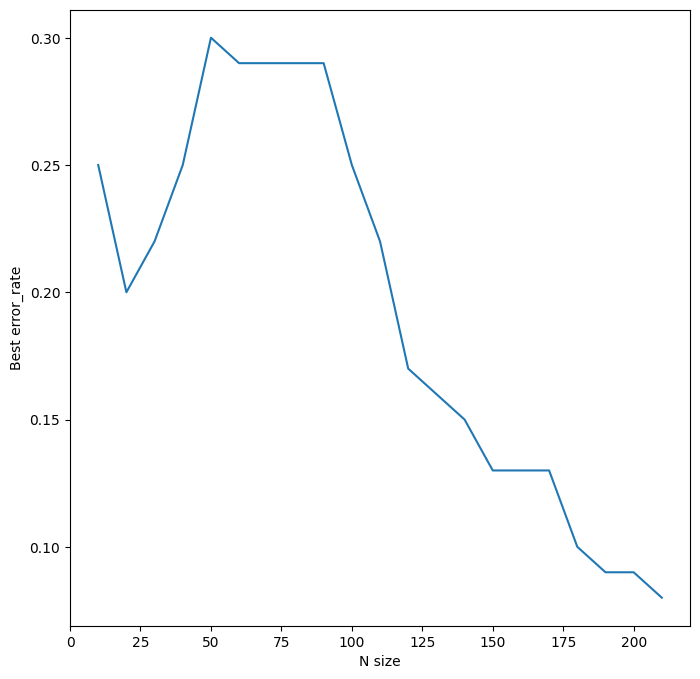

In [155]:
fig, axes = plt.subplots(1, 1, figsize = (8, 8))
axes.plot(N_range, bestError)
axes.set_xlabel("N size")
axes.set_ylabel("Best error_rate")
plt.show()

(d) Replace the Euclidean metric with the following metrics5 and test them. Summarize the test errors (i.e., when k = k∗) in a table. Use all of your training data and select the best k when {1, 6, 11, . . . , 196}.
i. Minkowski Distance:
A. which becomes Manhattan Distance with p = 1.


In [156]:
step = 5
k_range = range(1, 200, step)

train_input = train_set.iloc[:,:-2]
train_output = train_set.iloc[:,-1]
test_input = test_set.iloc[:,:-2]
test_output = test_set.iloc[:,-1]
    
def signal_for_multiThread_forK_multiMetric(metric, k_range = range(208, 0, step), weighted=False):
    signals = []
    for k in k_range:
        signals.append([k,train_input,train_output,test_input,test_output, metric, weighted])
    return signals

In [157]:
def calculate_KNN_by_one_loop_multiMetric(signal):
    min_error = 1
    k,train_input,train_output,test_input,test_output, metric, weighted = signal
    
    knn = KNN(k, metric, weighted=weighted)
    results_train = knn.fit(train_input, train_output, train_input, train_output)
    results_test = knn.fit(train_input, train_output, test_input, test_output)
    return [k, results_train, results_test]

In [158]:
multi_signals_forK_multiMetric = signal_for_multiThread_forK_multiMetric(metric="manhattan", k_range=k_range)

tmp = calculate_KNN_by_one_loop_multiMetric(multi_signals_forK_multiMetric[0])

In [159]:
with Pool(processes=processor) as pool:
    results_list = pool.map(calculate_KNN_by_one_loop_multiMetric, multi_signals_forK_multiMetric)
results_list.sort(key = takeFirst)

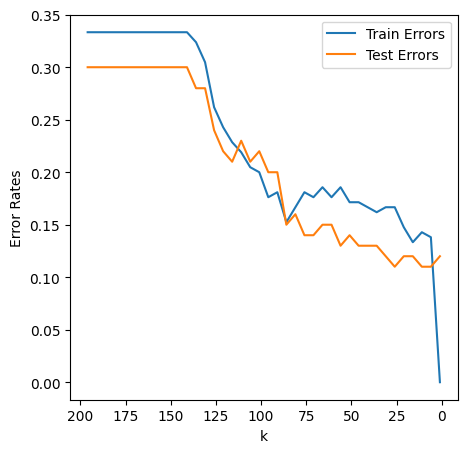

In [160]:
error_train = [r[1]["error_rate"] for r in results_list]
error_test = [r[2]["error_rate"] for r in results_list]

fig, axes = plt.subplots(1, 1, figsize=(5,5))
# print(error_test)
# plot error_rate fig
axes.plot(k_range, error_train, label="Train Errors")
axes.plot(k_range, error_test, label="Test Errors")
axes.invert_xaxis()
axes.set_xlabel("k")
axes.set_ylabel("Error Rates")
axes.legend()
plt.show()

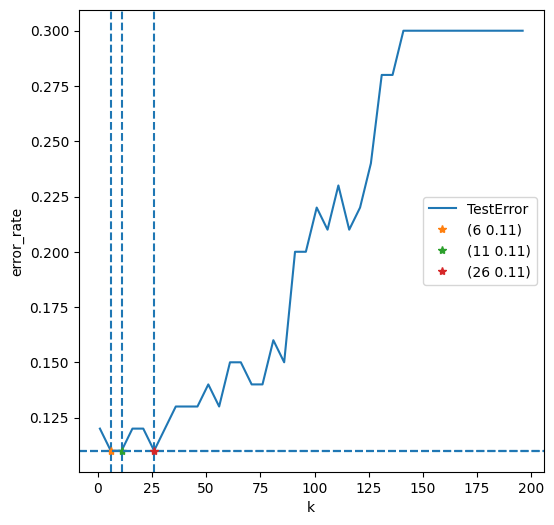

In [161]:
def find_best_k(k_range, error_train, error_test):
    best_error = 1
    best_k = []
    for i in range(len(k_range)):
        if error_test[i] < best_error:
            best_error = error_test[i]
            best_k = [[k_range[i], best_error]]
        elif error_test[i] == best_error:
            best_k.append([k_range[i], best_error])
    return best_k

def better_error_plot(k_range, error_train, error_test):
    best_k = find_best_k(k_range, error_train, error_test)
    
    fig, axes = plt.subplots(1, 1, figsize = (6, 6))
    axes.plot(k_range, error_test, label="TestError")
    for bk in best_k:
        axes.axhline(bk[1], linestyle = "--")
        axes.axvline(bk[0], linestyle = "--")
        axes.plot(bk[0], bk[1], '*', label='({} {})'.format(bk[0], bk[1]))
    axes.set_xlabel("k")
    axes.set_ylabel("error_rate")
    axes.legend()
    plt.show()

better_error_plot(k_range, error_train, error_test)

B. with log10(p) ∈ {0.1, 0.2, 0.3, . . . , 1}. In this case, use the k∗ you found for the Manhattan distance in 1(d)iA. What is the best log10(p)?


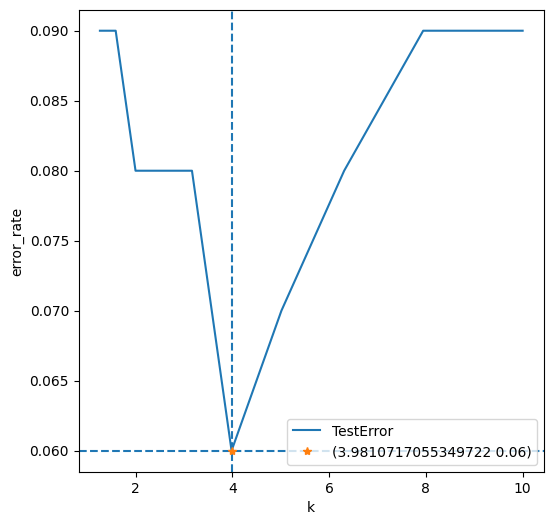

In [162]:
logp_range = np.linspace(0.1, 1, 10)
p_range = np.logspace(0.1, 1, 10)
error_train = []
error_test = []

for p in p_range:
    knn = KNN(6, metric="minkowski", p=p)
    results_train = knn.fit(train_input, train_output, train_input, train_output)
    error_train.append(results_train["error_rate"])
    results_test = knn.fit(train_input, train_output, test_input, test_output)
    error_test.append(results_test["error_rate"])


better_error_plot(p_range, error_train, error_test)

log10p == 0.6 is the best

C. which becomes Chebyshev Distance with p → ∞

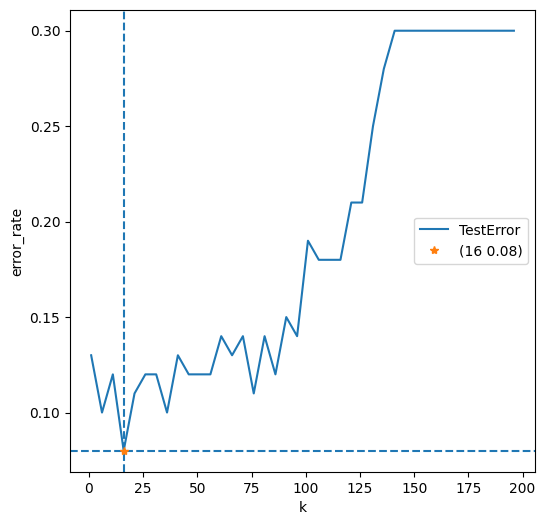

In [163]:
step = 5
k_range = range(1, 200, step)
multi_signals_forK_multiMetric = signal_for_multiThread_forK_multiMetric(metric="chebyshev", k_range=k_range)

with Pool(processes=processor) as pool:
    results_list = pool.map(calculate_KNN_by_one_loop_multiMetric, multi_signals_forK_multiMetric)
results_list.sort(key = takeFirst)
error_train = [r[1]["error_rate"] for r in results_list]
error_test = [r[2]["error_rate"] for r in results_list]
better_error_plot(k_range, error_train, error_test)

ii. Mahalanobis Distance.6

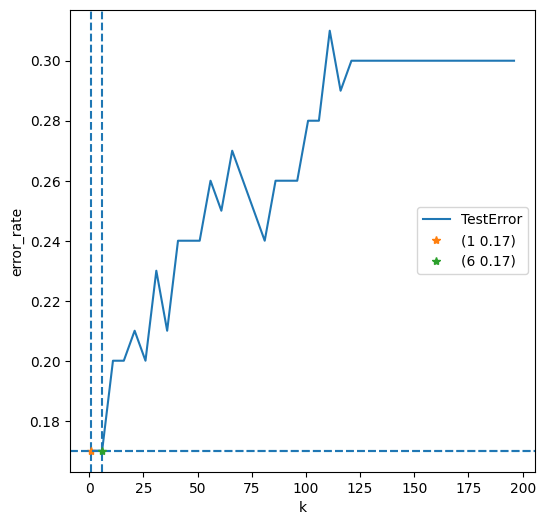

In [164]:
step = 5
k_range = range(1, 200, step)
multi_signals_forK_multiMetric = signal_for_multiThread_forK_multiMetric(metric="mahalanobis", k_range=k_range)
# tmp = calculate_KNN_by_one_loop_multiMetric(multi_signals_forK_multiMetric[0])

with Pool(processes=processor) as pool:
    results_list = pool.map(calculate_KNN_by_one_loop_multiMetric, multi_signals_forK_multiMetric)
results_list.sort(key = takeFirst)
error_train = [r[1]["error_rate"] for r in results_list]
error_test = [r[2]["error_rate"] for r in results_list]
better_error_plot(k_range, error_train, error_test)

(e) The majority polling decision can be replaced by weighted decision, in which the weight of each point in voting is inversely proportional to its distance from the query/test data point. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. Use weighted voting with Euclidean, Manhattan, and Chebyshev distances and report the best test errors when k ∈ {1, 6, 11, 16, . . . , 196}.

In [165]:
def pipline(k_range = range(1, 200, 5), metric="mahalanobis", weighted=True):
    multi_signals_forK_multiMetric = signal_for_multiThread_forK_multiMetric(metric=metric, k_range=k_range, weighted=True)
    # tmp = calculate_KNN_by_one_loop_multiMetric(multi_signals_forK_multiMetric[0])

    with Pool(processes=processor) as pool:
        results_list = pool.map(calculate_KNN_by_one_loop_multiMetric, multi_signals_forK_multiMetric)
    results_list.sort(key = takeFirst)
    error_train = [r[1]["error_rate"] for r in results_list]
    error_test = [r[2]["error_rate"] for r in results_list]
    better_error_plot(k_range, error_train, error_test)

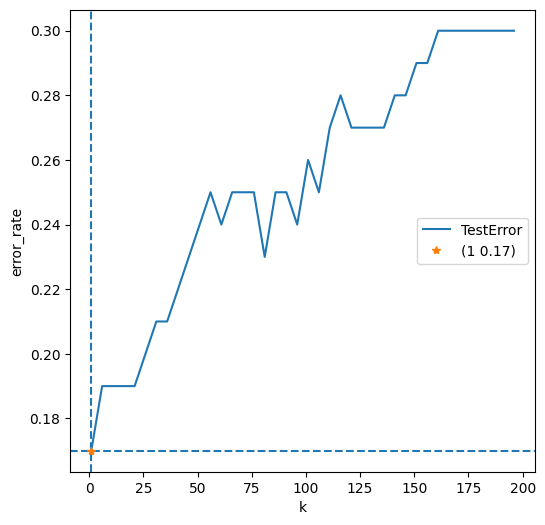

In [166]:
pipline(metric="mahalanobis")

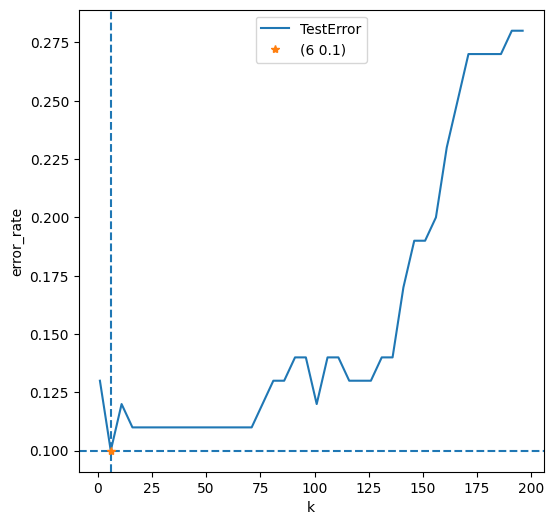

In [167]:
pipline(metric="euclidean")

For euclidean, best K: 6, error: 0.1

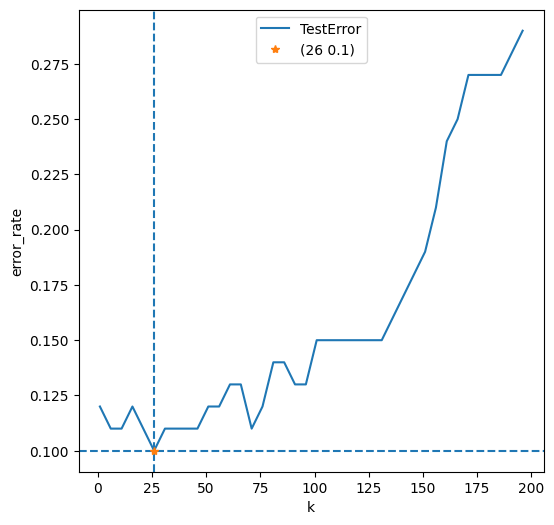

In [168]:
pipline(metric="manhattan")

For manhattan, best K: 26, error: 0.1

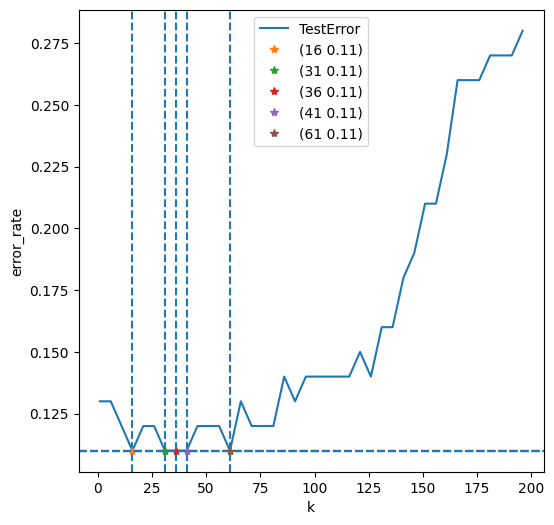

In [169]:
pipline(metric="chebyshev")

For chebyshev, best K: 16, 31, 36, 41, 61, error: 0.11

(f) What is the lowest training error rate you achieved in this homework?

It is 0 when K equal to 1. Because of the neighbor is itself.